In [145]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [146]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars
stoi = {n:i for i,n in enumerate(chars)}
itos = {n:i for i,n in stoi.items()}

block_size = 3
gen = torch.Generator().manual_seed(2147483647)

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = '.'*block_size
        for i, ch in enumerate(w + '.'):
            curr_x = context
            req = block_size - len(context)
            temp_w = w[:i]
            temp_w = temp_w[len(temp_w)-req:]
            curr_x += temp_w
            context = context[:-1]
            X.append([stoi[x_ch] for x_ch in curr_x])
            Y.append(stoi[ch])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(40)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [147]:
###### SUMMARY ########

In [148]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=gen) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (updated with back-propagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (calculated, with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = x_hat * self.gamma + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [149]:
n_embd = 10
n_hidden = 100
chars_len = len(chars)

C = torch.randn((chars_len, n_embd), generator=gen)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, chars_len) 
]
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, chars_len)
# ]

with torch.no_grad():
    # last layer: make less confident (to reduce error in initial phases)
    layers[-1].weight *= 0.1
    # apply gain for all other layers (due to tanh 5/3)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
total_count = sum(torch.numel(p) for p in parameters)
print(total_count)

for p in parameters:
    p.requires_grad = True

47497


In [150]:
max_steps = 200000
batch_size = 32

losses = []
update_data_ratio = []

for i in range(max_steps):
    ## batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    
    ## forward
    emb = C[Xtr[ix]]
    x = emb.view(-1, n_embd * block_size)
    
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Ytr[ix])

    ## backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    ## updation
    lr = 0.1 if i < 100000 else 0.01  # -> learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(loss.item())
    
    # keeping track of losses
    losses.append(loss.item())
    # keeping track of update to data ration
    with torch.no_grad():
        update_data_ratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # break for single forward and backward pass
#     if i > 1000:
#         break

print(loss.item())

3.2878618240356445
2.062969923019409
2.5163156986236572
2.224586009979248
2.219108819961548
2.0597710609436035
2.14825701713562
2.120673656463623
1.6901650428771973
2.095309257507324
2.1723453998565674
1.9694812297821045
2.19852352142334
1.943527340888977
2.378061532974243
2.121602773666382
2.0952506065368652
1.9491654634475708
2.0141193866729736
2.20931339263916
2.005638837814331


layer index (2) class Tanh mean: +0.01, std: 0.68, saturation: 14.47%
layer index (5) class Tanh mean: -0.02, std: 0.72, saturation: 17.47%
layer index (8) class Tanh mean: -0.01, std: 0.75, saturation: 15.59%
layer index (11) class Tanh mean: -0.01, std: 0.77, saturation: 17.88%
layer index (14) class Tanh mean: -0.01, std: 0.61, saturation: 4.78%


Text(0.5, 1.0, 'activation distribution')

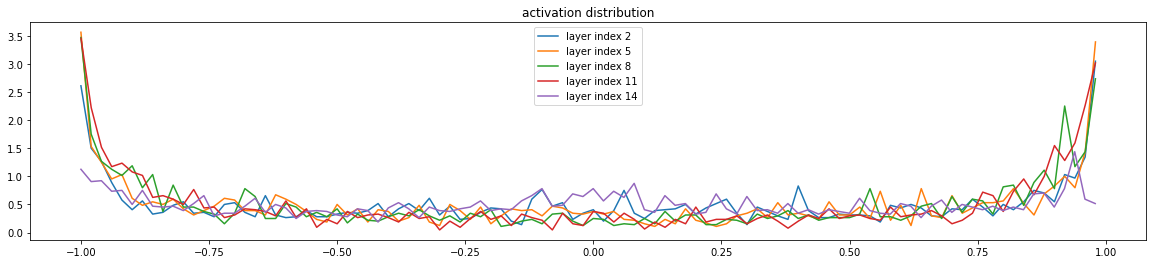

In [151]:
## visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer index (%d) ' %(i), end="")
        print('class', layer.__class__.__name__, end="")
        print(' mean: %+.2f, std: %.2f, saturation: %.2f%%' %(t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer index ' + str(i))
plt.legend(legends)
plt.title("activation distribution")

layer index (2) class Tanh mean: -0.000000, std: 0.004649
layer index (5) class Tanh mean: -0.000000, std: 0.004179
layer index (8) class Tanh mean: -0.000000, std: 0.003919
layer index (11) class Tanh mean: -0.000000, std: 0.003706
layer index (14) class Tanh mean: -0.000096, std: 0.005784


Text(0.5, 1.0, 'gradient distribution')

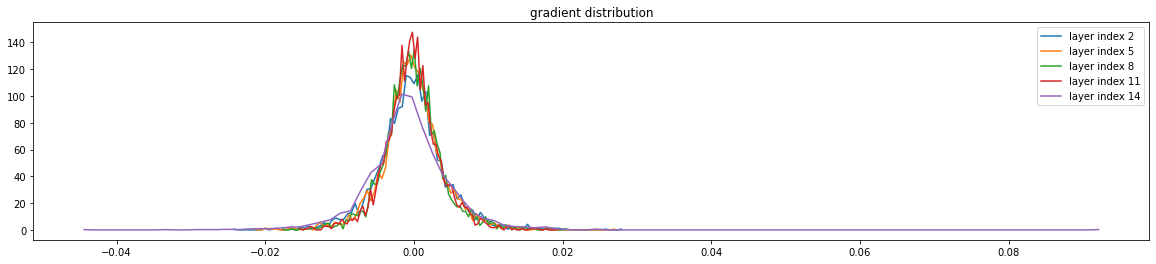

In [152]:
## visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer index (%d) ' %(i), end="")
        print('class', layer.__class__.__name__, end="")
        print(' mean: %+f, std: %f' %(t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer index ' + str(i))
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000000 | std 1.604057e-02 | grad:data ratio 1.460124e-02
weight  (30, 100) | mean -0.000552 | std 8.766817e-03 | grad:data ratio 2.117589e-02
weight (100, 100) | mean -0.000034 | std 5.932630e-03 | grad:data ratio 2.379702e-02
weight (100, 100) | mean +0.000005 | std 6.125425e-03 | grad:data ratio 2.494156e-02
weight (100, 100) | mean +0.000142 | std 5.741759e-03 | grad:data ratio 2.375001e-02
weight (100, 100) | mean +0.000050 | std 5.125815e-03 | grad:data ratio 2.137169e-02
weight  (100, 27) | mean +0.000000 | std 1.679774e-02 | grad:data ratio 7.269624e-02


Text(0.5, 1.0, 'weights gradient distribution')

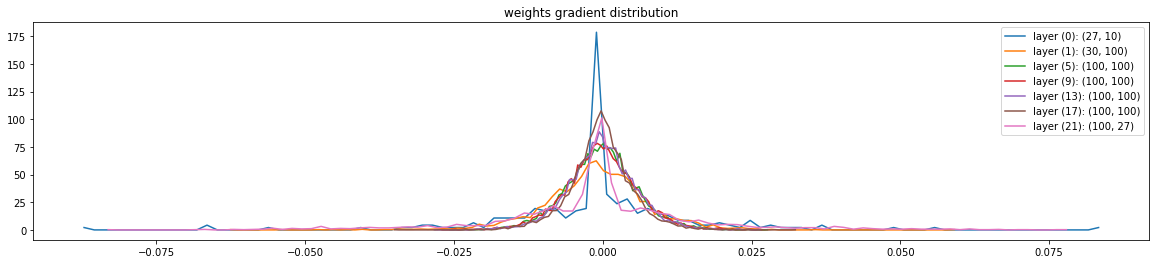

In [153]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print('weight %10s'%(tuple(p.shape),), end=" | ")
        print('mean %+f'%(t.mean()), end=' | ')
        print('std %e'%(t.std()), end=' | ')
        print('grad:data ratio %e'%(t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append('layer (%d): %s'%(i, tuple(p.shape)))
plt.legend(legends)
plt.title("weights gradient distribution")

Text(0.5, 1.0, 'update to data ratio')

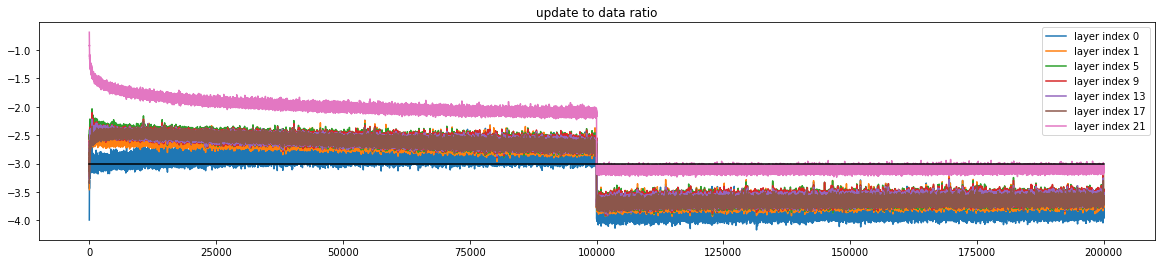

In [154]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
        legends.append('layer index ' + str(i))
plt.plot([0, len(update_data_ratio)], [-3, -3], '-k')
## approximately we need 1e-3, for a good ratio
plt.legend(legends)
plt.title("update to data ratio")